# Tweet like Trump: a one2seq Model

In this project we are going to build a model that takes a single value as an input, and outputs a tweet similar to those of [Donald Trump](https://twitter.com/realDonaldTrump). 

To create the inputs, we are going to do the following steps:
- Clean Trump's tweets.
- Create words vectors using pre-trained word vectors ([GloVe - Twitter 200d](https://nlp.stanford.edu/projects/glove/)).
- Average the dimensions of a tweet's word vectors.
- Use PCA to reduce the dimensions to 1.
- Order the tweets by their PCA values.

With this method, we will be able to produce tweets that are similar to their adjacent input values and analyze the context of Trump's tweets. To put another way, we will be able to, reasonably, control the style of the tweet that we want to generate, and the context, but to a lesser degree. 

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import operator
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from operator import itemgetter

In [7]:
# Import our data
train = pd.read_csv("tweets.csv")

## Inspect the data

In [8]:
train.head()

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...,text,photo,ThankAVet,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,127213,41112,NaN,NaN
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,141527,28654,NaN,NaN
2,16-11-11,11:14:20,Love the fact that the small groups of protest...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,183729,50039,NaN,NaN
3,16-11-11,2:19:44,Just had a very open and successful presidenti...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,214001,67010,NaN,NaN
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,178499,36688,NaN,NaN


In [9]:
train.shape

(7375, 12)

In [10]:
# Create a variable for the tweets
tweets = train.Tweet_Text

In [11]:
# Inspect some of the tweets
x = 0
for i in range(x,x+10):
    print(tweets[i])
    print()

Today we express our deepest gratitude to all those who have served in our armed forces. #ThankAVet https://t.co/wPk7QWpK8Z

Busy day planned in New York. Will soon be making some very important decisions on the people who will be running our government!

Love the fact that the small groups of protesters last night have passion for our great country. We will all come together and be proud!

Just had a very open and successful presidential election. Now professional protesters, incited by the media, are protesting. Very unfair!

A fantastic day in D.C. Met with President Obama for first time. Really good meeting, great chemistry. Melania liked Mrs. O a lot!

Happy 241st birthday to the U.S. Marine Corps! Thank you for your service!! https://t.co/Lz2dhrXzo4

Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before

Watching the returns at 9:45pm.
#ElectionNight #MAGA__ https://t.co/HfuJeRZbod

RT @IvankaT

# Prepare the Input Data

In [12]:
def clean_tweet(tweet):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[_"\-;%()|.,+&=*%]', '', tweet)
    tweet = re.sub(r'\.', ' . ', tweet)
    tweet = re.sub(r'\!', ' !', tweet)
    tweet = re.sub(r'\?', ' ?', tweet)
    tweet = re.sub(r'\,', ' ,', tweet)
    tweet = re.sub(r':', ' : ', tweet)
    tweet = re.sub(r'#', ' # ', tweet)
    tweet = re.sub(r'@', ' @ ', tweet)
    tweet = re.sub(r'd .c .', 'd.c.', tweet)
    tweet = re.sub(r'u .s .', 'd.c.', tweet)
    tweet = re.sub(r' amp ', ' and ', tweet)
    tweet = re.sub(r'pm', ' pm ', tweet)
    tweet = re.sub(r'news', ' news ', tweet)
    tweet = re.sub(r' . . . ', ' ', tweet)
    tweet = re.sub(r' .  .  . ', ' ', tweet)
    tweet = re.sub(r' ! ! ', ' ! ', tweet)
    tweet = re.sub(r'&amp', 'and', tweet)
    return tweet

In [13]:
# Clean the tweets and append those with a length > 0 to the clean_tweets list
clean_tweets = []
for tweet in tweets:
    tweet = clean_tweet(tweet)
    if len(tweet) > 0:
        clean_tweets.append(tweet)

In [15]:
# Check to ensure the tweets have been clean properly
x = 0
for i in range(x,x+10):
    print(clean_tweets[i])  
    print()

today we express our deepest gratitude to all those who have served in our armed forces  # thankavet 

busy day planned in new york will soon be making some very important decisions on the people who will be running our government !

love the fact that the small groups of protesters last night have passion for our great country we will all come together and be proud !

just had a very open and successful presidential election now professional protesters incited by the media are protesting very unfair !

a fantastic day in dc met with president obama for first time really good meeting great chemistry melania liked mrs o a lot !

happy 241st birthday to the us marine corps ! thank you for your service ! 

such a beautiful and important evening ! the forgotten man and woman will never be forgotten again we will all come together as never before

watching the returns at 9 : 45 pm 
 # electionnight  # maga 

rt  @ ivankatrump :  such a surreal moment to vote for my father for president of t

In [16]:
# Count the total number of occurences of each word
word_counts = {}
for tweet in clean_tweets:
    for word in tweet.split():
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1
print("Size of Vocabulary:", len(word_counts.keys()))

Size of Vocabulary: 11612


In [17]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/Users/Dave/Desktop/Programming/glove.twitter.27B/glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 1193514


In [18]:
# Create an 'average' embedding for each tweet

embedding_dim = 200 # Use 200 to match GloVe's embedding size

embed_tweets = [] # Contains the 'average' embedding for each tweet
total_embeds = 0 
null_embeds = 0 

for tweet in clean_tweets:
    avg_embed = np.zeros(embedding_dim) # Set default embedding for each tweet
    for word in tweet.split():
        total_embeds += 1
        embed = embeddings_index.get(word)
        if embed is not None:
            avg_embed += embed # Add embedding's values to vectors
        else:
            null_embeds += 1
    embed_tweets.append(avg_embed/len(tweet.split()))

print("Total Number of Embeddings:", total_embeds)
print("Number of Null Embeddings:", null_embeds)
print("% of Embeddings that are Null: {}%".format(round(null_embeds/total_embeds,4)*100))

Total Number of Embeddings: 138153
Number of Null Embeddings: 12386
% of Embeddings that are Null: 8.97%


In [19]:
# Reduce the dimensions of each tweet to 1
pca = PCA(n_components=1, random_state = 2)
pca_tweets = pca.fit_transform(embed_tweets)

In [20]:
# Order the tweets based on their PCA values, from low to high
# Similar tweets will be closer together
pca_tweets_list = [] # Contains the pca values
for tweet in pca_tweets:
    pca_tweets_list.append(tweet[0])

order = np.array(pca_tweets_list).argsort()
pca_labels = order.argsort()
pca_labels *= 2 # Multiple the labels by 2 so generated tweets can have odd values and 
                # Even values will represent tweets that were used for training

In [21]:
# Inspect pca_labels
pca_labels[:10]

array([ 4540,   464,   206,  4652,  5004,  4932,   196, 13660,  6736,  8018])

In [22]:
# Group tweets by similarity
kmeans = KMeans(n_clusters=4, max_iter = 1000, n_init = 20, random_state=2).fit(pca_tweets)
labels = kmeans.labels_

Note: After checking the results of using 3 - 10 clusters, I thought 4 clusters can best sort Trump's tweets into distinct groups.

In [23]:
# The number of tweets in each group.
pd.DataFrame(labels)[0].value_counts()

3    2782
1    2600
2    1674
0     315
Name: 0, dtype: int64

In [24]:
# Words to not include when finding the most common words in each group
stop_words = ['be','on','!','at','.',':','...','@',',','#','will','.m','in','a','the','with','to','by','and','my','is',
              'of','for','new','via','are','that','has','have','all','as','it','so','they','do','he','just','this',
              'was','who','your','from','his','about','get','but','am','up','if','can','would','than','should','dont',
              'had','or','were','did','there','got','even','its','an']

In [27]:
def top_n_words(group, n_words):
    '''Find the n most common words in each group'''
    vocab = {} # Create the vocabulary for each group
    for i in range(len(clean_tweets)):
        if labels[i] == group:
            for word in clean_tweets[i].split():
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1
      
    # Sort the vocab from most to least common words
    sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
    top_n_words = []
    for word, value in sorted_vocab:
        if word not in stop_words:
            top_n_words.append(word)
        if len(top_n_words) == n_words:
            break
    print(top_n_words)

In [28]:
# The most common words in each group
groups = len(np.unique(labels))
for i in range(groups):
    print("Group #",i+1)
    top_n_words(i, 10)

Group # 1
['trump2016', 'makeamericagreatagain', 'realdonaldtrump', 'trump', 'rt', 'poll', 'danscavino', 'news', 'gop', '1']
Group # 2
['realdonaldtrump', 'you', 'trump', 'i', 'great', 'thank', 'we', 'news', 'america', 'rt']
Group # 3
['realdonaldtrump', 'trump', 'you', 'trump2016', 'thank', 'makeamericagreatagain', 'rt', 'news', 'poll', 'donald']
Group # 4
['i', 'you', 'great', 'we', 'not', 'me', 'people', 'hillary', 'thank', 'our']


In [29]:
# The most common words for all of Trump's tweets
n_words = 100
sorted_vocab = sorted(word_counts.items(), key=operator.itemgetter(1), reverse=True)
top_n_words = []
for word, value in sorted_vocab:
    if word not in stop_words:
        top_n_words.append(word)
    if len(top_n_words) == n_words:
        break
print("Trump's {} most popular tweeted words (not including stop words):".format(n_words))
print(top_n_words)

Trump's 100 most popular tweeted words (not including stop words):
['you', 'i', 'realdonaldtrump', 'trump', 'great', 'thank', 'we', 'trump2016', 'me', 'hillary', 'news', 'not', 'makeamericagreatagain', 'america', 'rt', 'people', 'our', '?', 'fox', 'out', 'poll', 'make', 'no', 'again', 'donald', 'very', 'clinton', 'cnn', 'now', 'pm', 'president', 'like', 'more', 'big', 'vote', 'debate', 'tonight', 'she', 'what', 'time', 'us', 'one', 'cruz', 'her', 'crooked', 'going', 'only', 'country', 'last', 'why', 'today', 'back', 'join', 'said', 'many', 'never', 'him', 'good', 'iowa', 'been', 'watch', 'much', 'how', 'win', 'when', 'night', 'love', 'want', 'media', 'enjoy', 'polls', 'bad', 'gop', 'support', 'tomorrow', 'go', 'job', 'campaign', 'see', 'interviewed', 'rubio', 'jeb', 'crowd', 'amazing', 'ted', 'their', 'cant', 'need', 'really', 'nice', 'them', 'thanks', 'wow', 'show', '00', 'obama', '7', 'over', 'speech', 'way']


In [30]:
def print_tweet_group(group, n_tweets):
    '''Prints the first n_tweets in a group'''
    count = 1
    for i in range(len(clean_tweets)):
        if labels[i] == group:
            print("#{}: {}".format(count, clean_tweets[i]))
            count += 1
            if count == n_tweets+1:
                break

In [31]:
# Print the first few tweets in each group
n_tweets = 5
for i in range(groups):
    print("Group #",i+1)
    print_tweet_group(i,n_tweets)
    print()

Group # 1
#1:  # electionday 
#2: rt  @ donaldjtrumpjr :  thanks new hampshire ! !
 # nh  # newhampshire  # maga 
#3:  # draintheswamp !

#4:  # makeamericagreatagain  # 6days 
#5:  @ pynance :  evangelical women live at  # trumptower  @ pdpryor1  @ cissieglynch  @ saysgabrielle 

Group # 2
#1: rt  @ ivankatrump :  such a surreal moment to vote for my father for president of the united states ! make your voice heard and vote !  # election2
#2: rt  @ erictrump :  join my family in this incredible movement to  # makeamericagreatagain ! now it is up to you ! please  # vote for america ! https : 
#3: rt  @ donaldjtrumpjr :  final push ! eric and i doing dozens of radio interviews we can win this thing ! get out and vote !  # maga  # electionday ht
#4: just out according to  @ cnn :  utah officials report voting machine problems across entire country
#5: rt  @ erictrump :  sean hannity :  if hillary wins you own it 

Group # 3
#1: watching the returns at 9 : 45 pm 
 # electionnight  # maga 

The four groups look like they can be categorized as:
1. Short with many # or @
2. Retweets with long texts
3. Relating to data/time/location
4. Longer tweets written by Trump

In [34]:
# Visualize the tweets with TSNE
model = TSNE(n_components=2, random_state=2)
TSNE_tweets = model.fit_transform(embed_tweets)

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
//anaconda/lib/python3.5/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
//anaconda/lib/python3.5/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
//anaconda/lib/python3.5/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
//anaco

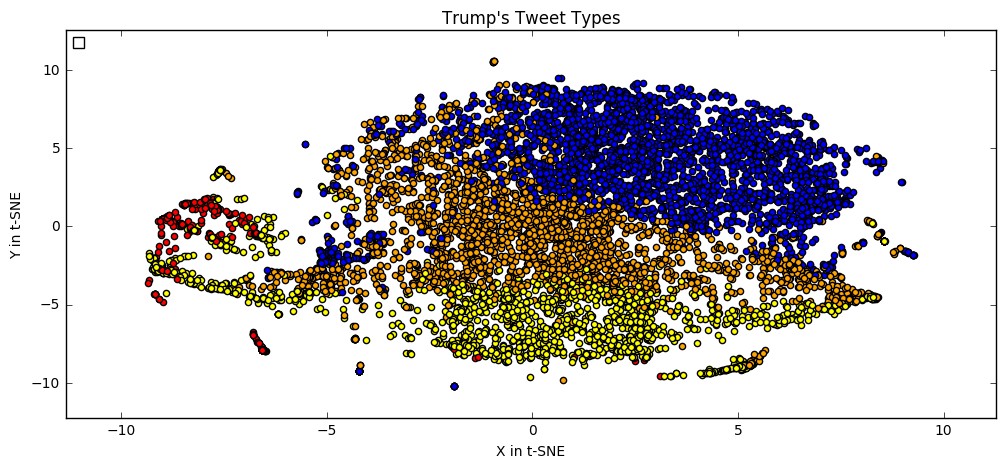

In [35]:
# Build a scatter plot to visualize the tweets.
color_map = {0:'red', 1:'orange', 2:'yellow', 3:'blue'}
plt.figure(figsize=(12,5))

for i in range(len(TSNE_tweets)):
    plt.scatter(x = TSNE_tweets[i][0], 
                y = TSNE_tweets[i][1],
                c = color_map[labels[i]])
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.title('Trump\'s Tweet Types')

offset = 2
x_min = min(TSNE_tweets, key=itemgetter(0))[0] - offset
x_max = max(TSNE_tweets, key=itemgetter(0))[0] + offset
y_min = min(TSNE_tweets, key=itemgetter(1))[1] - offset
y_max = max(TSNE_tweets, key=itemgetter(1))[1] + offset

axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
plt.show()

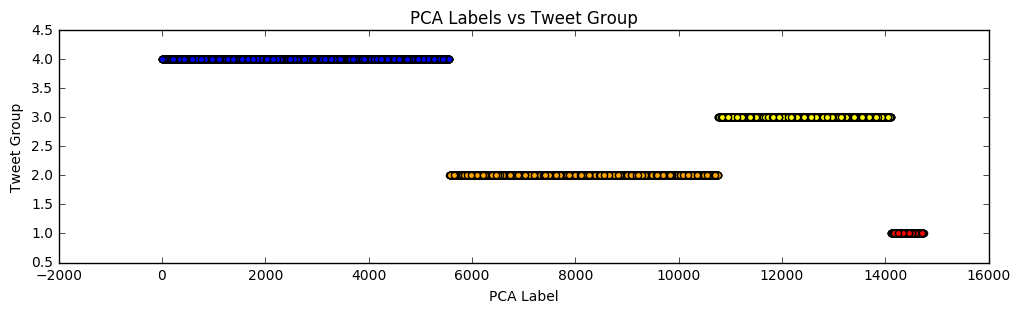

In [36]:
# Create a scatterplot to visualize the tweet groups by the PCA labels
plt.figure(figsize=(12,3))
for i in range(len(TSNE_tweets)):
    plt.scatter(x = pca_labels[i], 
                y = labels[i]+1,
                c = color_map[labels[i]])
    
plt.xlabel('PCA Label')
plt.ylabel('Tweet Group')
plt.title('PCA Labels vs Tweet Group')
    
plt.show()

There's a little bit of overlap between the PCA labels and tweet groups at the extremes, otherwise, it's really nice to see the tweets organized as well as they are.

In [52]:
# Limit the vocab that we will use to words that appear ≥ threshold 

threshold = 10

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<GO>","<PAD>","<EOS>"]   

for code in codes:
    vocab_to_int[code] = len(vocab_to_int)+1

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

word_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(word_ratio))

Total Number of Unique Words: 11612
Number of Words we will use: 1375
Percent of Words we will use: 11.84%


Note: We could use more words, but that would make it more difficult to train the model. I think it would be better to use fewer words and make very similar tweets than use more words that look less like Trump's tweets.

In [53]:
# Change the tweets from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
int_tweets = []

for tweet in clean_tweets:
    int_tweet = []
    for word in tweet.split():
        if word in vocab_to_int:
            int_tweet.append(vocab_to_int[word])
        else:
            int_tweet.append(vocab_to_int["<UNK>"])
    int_tweets.append(int_tweet)

In [54]:
# Find the length of tweets
lengths = []
for tweet in int_tweets:
    lengths.append(len(tweet))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [55]:
lengths.describe()

,counts
count,7371.000000
mean,18.742776
std,6.713868
min,1.000000
25%,14.000000
50%,20.000000
75%,24.000000
max,35.000000


In [56]:
# Keep only the tweets that are between the min and max lengths and ≤ the <UNK> limit

max_tweet_length = 25
min_tweet_length = 1
unk_limit = 1

short_tweets = []
short_labels = []

for i in range(len(int_tweets)):
    unk_count = 0
    if len(int_tweets[i]) <= max_tweet_length and len(int_tweets[i]) >= min_tweet_length:
        if len(int_tweets[i]) == 1:
            if int_tweets[i][0] != vocab_to_int['<UNK>']:
                short_tweets.append(int_tweets[i])
                short_labels.append(pca_labels[i])
        else:
            for word in int_tweets[i]:
                if word == vocab_to_int['<UNK>']:
                    unk_count += 1
            if unk_count <= unk_limit:
                short_tweets.append(int_tweets[i])
                short_labels.append(pca_labels[i])
        

usage_precent = round(len(short_tweets)/len(clean_tweets),4)*100
        
print("Total Number of Tweets:", len(clean_tweets))
print("Number of Tweets we will use:", len(short_tweets))
print("Percent of Tweets we will use: {}%".format(usage_precent))

Total Number of Tweets: 7371
Number of Tweets we will use: 2205
Percent of Tweets we will use: 29.909999999999997%


In [57]:
# Sort tweets by length to train faster and reduce padding.
sorted_tweets = []
sorted_labels = []

for length in range(1,max_tweet_length+1):
    for i in range(len(short_tweets)):
        if length == len(short_tweets[i]):
            sorted_tweets.append(short_tweets[i])
            sorted_labels.append([short_labels[i]])
            
print(len(sorted_tweets))
print(len(sorted_labels))

2205
2205


In [58]:
# Find the number/ratio of words that are <UNK>
n_words = 0
unk_words = 0
for tweet in sorted_tweets:
    for int in tweet:
        n_words += 1
        if int == vocab_to_int["<UNK>"]:
            unk_words += 1
            
unk_ratio = round(unk_words/n_words,4)*100
            
print("Total Number of Words:", n_words)
print("Number of uses of <UNK>:", unk_words)
print("Percent of words that are <UNK>: {}%".format(unk_ratio))

Total Number of Words: 29533
Number of uses of <UNK>: 1246
Percent of words that are <UNK>: 4.22%


Note: I wanted to limit the number of times UNK is used in the training data, which is why the UNK limit is set to just one.

## Build and Train the Model

In [59]:
def model_inputs():
    '''Create palceholders for inputs to the model'''
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    return input_data, targets, lr, keep_prob

In [60]:
def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last id from each batch and concat the <GO> to the begining of each batch'''
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [61]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, sequence_length):
    '''Create the encoding layer'''
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    enc_cell = tf.contrib.rnn.MultiRNNCell([lstm] * num_layers)
    _, enc_state = tf.nn.dynamic_rnn(enc_cell,
                                     rnn_inputs, 
                                     sequence_length,
                                     dtype=tf.float32)
    return enc_state

In [62]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope,
                         output_fn, keep_prob, batch_size):
    '''Decode the training data'''
    train_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    train_pred, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(
        dec_cell, train_decoder_fn, dec_embed_input, sequence_length, scope=decoding_scope)
    train_pred_drop = tf.nn.dropout(train_pred, keep_prob)
    return output_fn(train_pred_drop)    

In [63]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn):
    '''Decode the prediction data'''
    infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(
        output_fn, encoder_state, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size)
    infer_logits, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(
        dec_cell, infer_decoder_fn, scope=decoding_scope)
    return infer_logits

In [64]:
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size,
                   num_layers, vocab_to_int, keep_prob, batch_size):
    '''Create the decoding cell and input the parameters for the training and inference decoding layers'''
    with tf.variable_scope("decoding") as decoding_scope:
        lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
        drop = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob)
        dec_cell = tf.contrib.rnn.MultiRNNCell([drop] * num_layers)
        
        weights = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1)
        biases = tf.zeros_initializer()
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, 
                                                                vocab_size, 
                                                                None, 
                                                                scope=decoding_scope,
                                                                weights_initializer = weights,
                                                                biases_initializer = biases)

        train_logits = decoding_layer_train(encoder_state, 
                                            dec_cell, 
                                            dec_embed_input, 
                                            sequence_length, 
                                            decoding_scope, 
                                            output_fn, 
                                            keep_prob, 
                                            batch_size)
        decoding_scope.reuse_variables()
        infer_logits = decoding_layer_infer(encoder_state, 
                                            dec_cell, 
                                            dec_embeddings, 
                                            vocab_to_int['<GO>'],
                                            vocab_to_int['<EOS>'], 
                                            sequence_length - 1, 
                                            vocab_size,
                                            decoding_scope, 
                                            output_fn)

    return train_logits, infer_logits

In [65]:
def one2seq_model(input_data, target_data, keep_prob, batch_size, sequence_length, vocab_size, 
                  embedding_size, rnn_size, num_layers, vocab_to_int):
    '''Use the previous functions to create the training and inference logits'''
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, 
                                                       max(short_labels)+1, 
                                                       embedding_size,
                                                       initializer = tf.random_uniform_initializer(-1,1))
    enc_state = encoding_layer(enc_embed_input, rnn_size, num_layers, keep_prob, sequence_length)

    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embedding_size], -1, 1))

    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, 
                                             dec_input)
    
    train_logits, infer_logits = decoding_layer(dec_embed_input, 
                                                dec_embeddings, 
                                                enc_state, 
                                                vocab_size, 
                                                sequence_length, 
                                                rnn_size, 
                                                num_layers, 
                                                vocab_to_int, 
                                                keep_prob, 
                                                batch_size)
    return train_logits, infer_logits

In [66]:
def pad_tweets_batch(tweets_batch):
    """Pad tweets with <PAD> so that each tweet of a batch has the same length"""
    max_tweet = max([len(tweet) for tweet in tweets_batch])
    return [tweet + [vocab_to_int['<PAD>']] * (max_tweet - len(tweet)) for tweet in tweets_batch]

In [67]:
def get_batches(labels, tweets, batch_size):
    """Batch labels and tweets together"""
    for batch_i in range(0, len(labels)//batch_size):
        start_i = batch_i * batch_size
        labels_batch = np.array(labels[start_i:start_i + batch_size])
        tweets_batch = tweets[start_i:start_i + batch_size]
        padded_tweets_batch = np.array(pad_tweets_batch(tweets_batch))
        yield labels_batch, padded_tweets_batch

In [68]:
# Set the Hyperparameters
epochs = 100
batch_size = 32
rnn_size = 512
num_layers = 2
embedding_size = 200
learning_rate = 0.005
keep_probability = 0.5

In [69]:
# Build the graph
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob = model_inputs()
    # Sequence length will be the max tweet length for each batch
    sequence_length = tf.placeholder_with_default(max_tweet_length, None, name='sequence_length')
    # Find the shape of the input data for sequence_loss
    input_shape = tf.shape(input_data)

    # Create the training and inference logits
    train_logits, inference_logits = one2seq_model(input_data, 
                                                   targets, 
                                                   keep_prob, 
                                                   batch_size, 
                                                   sequence_length, 
                                                   len(vocab_to_int), 
                                                   embedding_size, 
                                                   rnn_size, 
                                                   num_layers, 
                                                   vocab_to_int)

    # Create a tensor for the inference logits, needed to load a checkpoint version of the model
    tf.identity(inference_logits, 'logits')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

Note: There is no validation data because it did not prove to be a good indicator for the quality of the generated tweets. 

In [71]:
# Train the Model
learning_rate_decay = 0.9
min_learning_rate = 0.0005
display_step = 20 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the epoch loss does decrease in 3 consecutive epochs, stop training
epoch_check = ((len(sorted_labels))//batch_size)-1 # Modulus for checking epoch loss
epoch_loss = 0 
batch_loss = 0
summary_epoch_loss = [] # Record the epoch loss for saving improvements in the model

checkpoint = "best_model.ckpt" 

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(1, epochs+1):
        epoch_loss = 0
        batch_loss = 0
        
        for batch_i, (labels_batch, tweets_batch) in enumerate(
                get_batches(sorted_labels, sorted_tweets, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: labels_batch,
                 targets: tweets_batch,
                 lr: learning_rate,
                 sequence_length: tweets_batch.shape[1],
                 keep_prob: keep_probability})

            batch_loss += loss
            epoch_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_labels) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % epoch_check == 0 and batch_i > 0:
                print("Average loss for this epoch:", round(epoch_loss/epoch_check,3))
                summary_epoch_loss.append(epoch_loss)
                
                # If the epoch loss is at a new minimum, save the model
                if epoch_loss <= min(summary_epoch_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                    
        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break

Epoch   1/100 Batch   20/68 - Loss:  5.612, Seconds: 8.12
Epoch   1/100 Batch   40/68 - Loss:  5.004, Seconds: 13.41
Epoch   1/100 Batch   60/68 - Loss:  5.228, Seconds: 17.58
Average loss for this epoch: 5.319
New Record!
Epoch   2/100 Batch   20/68 - Loss:  3.857, Seconds: 9.14
Epoch   2/100 Batch   40/68 - Loss:  4.254, Seconds: 14.14
Epoch   2/100 Batch   60/68 - Loss:  4.667, Seconds: 18.45
Average loss for this epoch: 4.363
New Record!
Epoch   3/100 Batch   20/68 - Loss:  3.346, Seconds: 11.80
Epoch   3/100 Batch   40/68 - Loss:  3.829, Seconds: 25.49
Epoch   3/100 Batch   60/68 - Loss:  4.329, Seconds: 21.70
Average loss for this epoch: 3.954
New Record!
Epoch   4/100 Batch   20/68 - Loss:  2.926, Seconds: 18.06
Epoch   4/100 Batch   40/68 - Loss:  3.477, Seconds: 13.08
Epoch   4/100 Batch   60/68 - Loss:  4.043, Seconds: 28.92
Average loss for this epoch: 3.613
New Record!
Epoch   5/100 Batch   20/68 - Loss:  2.506, Seconds: 21.18
Epoch   5/100 Batch   40/68 - Loss:  3.253, Sec

## Generate New Tweets

In [72]:
def vectorize_tweet(tweet):
    '''Just like for the training data, this creates the average embedding for the inputted tweet'''
    vect_tweet = []
    vectors = np.zeros(embedding_dim)
    for word in tweet.split():
        vector = embeddings_index.get(word)
        if vector is not None:
            vectors += vector
    return vectors/len(tweet.split())

In [79]:
# Create a tweet and it will be matched to the closest tweet from the dataset
create_tweet = "I need your help to make america great again! #maga"

create_tweet = clean_tweet(create_tweet)

create_tweet_vect = vectorize_tweet(create_tweet)

create_tweet_pca = pca.transform(create_tweet_vect)

# We need to match the tweet so that we can find its appropriate PCA label
similar_tweet = min(pca_tweets_list, key=lambda x:abs(x-create_tweet_pca))

for tweet in enumerate(pca_tweets_list):
    if tweet[1] == similar_tweet:
        print(pca_labels[tweet[0]])
        break

3464


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


You can use the outputted value above as your tweet_type. This will show you the tweet, from the training data, that is most similar to your created tweet. You might notice that your created tweet does not look like the most similar tweet. The is partially due to the lack of data that we are working with and the limitations of how our input data was created.

In [80]:
# Prints the tweet that has the closest label to your tweet type.
# Note: Odd values are not in the dataset. You should use these values to generate new tweets.
# Note2: If you generate a tweet using a tweet_type that is in the training data,     
#        it will likely reproduce that same tweet.
tweet_type = 3464

closest_type = min(short_labels, key=lambda x:abs(x-tweet_type))
words = []
for tweet in enumerate(short_labels):
    if tweet[1] == closest_type:
        for num in short_tweets[tweet[0]]:
            words.append(int_to_vocab[num])
print(" ".join(words))
print()
print("Tweet type in training data:", tweet_type in short_labels)

hillary is the most corrupt person to ever run for the presidency of the united states # draintheswamp

Tweet type in training data: False


In [76]:
# The range of tweet types that were used in the training data.
# I recommend that you stay within this range to produce the best tweets, but give larger values a try too.
print(min(short_labels), ",", max(short_labels))

0 , 14736


As the reminder, the 4 tweet groups had the ranges:
1. 14,400 - 14,736
  - ex. # makeamericagreatagain  # 6days 
2. 5,500 - 11,000 
  - ex. rt  @ donaldjtrumpjr :  final push ! eric and i doing dozens of radio interviews we can win this thing ! get out and vote !  # maga  # electionday
3. 11,000 - 14,400 
  - ex. watching the returns at 9 : 45 pm # electionnight  # maga 
4. 0 - 5,500
  - ex. busy day planned in new york will soon be making some very important decisions on the people who will be running our government !

In [78]:
# Select type of tweet
tweet_type = 14501

checkpoint = "./" + checkpoint

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    sequence_length = loaded_graph.get_tensor_by_name('sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    tweet_logits = sess.run(logits, {input_data: [[tweet_type]], 
                                     sequence_length: np.random.randint(3,15),
                                     keep_prob: 1.0})[0] 

# Remove the padding from the tweet
pad = vocab_to_int["<PAD>"]

print('Tweet')
print('  Word Ids:      {}'.format([i for i in np.argmax(tweet_logits, 1) if i != pad]))
print('  Tweet: {}'.format(" ".join([int_to_vocab[i] for i in np.argmax(tweet_logits, 1) if i != pad])))

Tweet
  Word Ids:      [1247, 908, 809, 881, 224, 1334, 224, 719]
  Tweet: thank you arizona ! # makeamericagreatagain # trump2016


## Summary

I hope that you enjoyed this project and learned something from it. From the amount of data that we are working with, I am very pleased with the quality of generated tweets. It would be nice to have more control over the type of tweet that we are generating. Having the ability to use a key word would be useful, but this would also alter the structure of the input, which I think is one of the best features of the model. I really like how such a simple input can generate a very good, and somewhat intended tweet (the style of the tweet can be reasonably managed).

Thanks for reading!